# Imports and data

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from ESN.ESN import *
from Helper.utils import nrmse
import os
from MackeyGlass.MackeyGlassGenerator import run
import time
import seaborn as sns

sns.set_style('whitegrid')
sns.despine()
sns.set_context('notebook', font_scale=1.5)

USE_NEW_DATA = False

if USE_NEW_DATA:
    data = np.array(run(15100, beta=0.3, gamma=0.2)).reshape(-1, 1)
else:
    data = np.array(run(15100)).reshape(-1, 1)
    
split = 14100
X_train = np.array(data[:split-1])
y_train = np.array(data[1:split])
X_valid = np.array(data[split-1:-1])
y_valid = np.array(data[split:])
data_mean = np.mean(data)

if 0:
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 12))
    ax1.plot(range(1000), data[:1000])
    ax2.plot(range(1000), data_new[:1000])
    plt.show()

    print(np.sum((data - data_new)**2))

# View best LCESN grid-search results

In [3]:
res_files = os.listdir('Results/LCESN')
#print(res_files)

results = pkl.load(open('Results/LCESN/Tue-Mar-20-16:54:59-2018.p'))
results_list = results.items()
print(len(results_list))
results_list = sorted(results_list, key=lambda x: np.mean(x[1]))

for k, v in results_list[:3]:
    print(k)
    print(v)

512

        num_res: 10
res_sizes:[200 200 200 200 200 200 200 200 200 200]
echo_params:[0.84999999999999998, 0.81111111111111112, 0.77222222222222214, 0.73333333333333328, 0.69444444444444442, 0.65555555555555556, 0.6166666666666667, 0.57777777777777772, 0.53888888888888886, 0.5]
input_scales:[0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001]
spectral_scales:[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        regulariser: 0.000100
[0.017733589389141727, 0.0054939505444227066, 0.086991286698266362]

        num_res: 10
res_sizes:[200 200 200 200 200 200 200 200 200 200]
echo_params:[0.84999999999999998, 0.81111111111111112, 0.77222222222222214, 0.73333333333333328, 0.69444444444444442, 0.65555555555555556, 0.6166666666666667, 0.57777777777777772, 0.53888888888888886, 0.5]
input_scales:[0.20000000000000001, 0.288888888888

# Run LCESN experiments

In [9]:
def run_tests_LCESN(n_runs=10):
    errors = []
    predics = []
    for _ in range(n_runs):
        start_time = time.time()

        model = LCESN(
            1, 1, num_reservoirs=10, 
            reservoir_sizes = np.linspace(200, 200, 10).astype(int),
            echo_params=np.linspace(0.85, 0.5, 10),
            regulariser=1e-4
        )
        model.initialize_input_weights(
            scales=np.linspace(0.2, 0.2, 10)
        )
        model.initialize_reservoir_weights(
            spectral_scales=np.linspace(1.0, 1.0, 10)
        )

        model.train(X_train, y_train)

        y_pred = []
        u_n = np.array(X_valid[0])
        for _ in range(len(data[split:])):
            u_n = np.array(model.forward(u_n))
            y_pred.append(np.array(u_n))

        print('Took %f seconds.' % (time.time() - start_time))

        y_pred = np.array(y_pred).squeeze()
        predics.append(y_pred)

        error = nrmse(y_valid, y_pred, data_mean)
        print('NRMSE: %f' % error)
        errors.append(error)

    raw_input('Press enter to save these results.')
    to_save = dict()
    to_save[model.info()] = errors
    
    title = 'Results/LCESN/GOOD'+time.asctime()[3:-5].replace(' ', '-')+'.p'
    if USE_NEW_DATA:
        title = 'NEW_DATA_' + title
    pkl.dump(to_save, open(title, 'wb'))
    
    return errors, predics
    
errors, predics = run_tests_LCESN(n_runs=10)

Took 10.444314 seconds.
NRMSE: 0.272667
Took 11.032536 seconds.
NRMSE: 0.074477
Took 11.463629 seconds.
NRMSE: 0.181475
Took 11.156900 seconds.
NRMSE: 0.414519
Took 11.216194 seconds.
NRMSE: 0.403514
Took 11.354171 seconds.
NRMSE: 0.439118
Took 10.150858 seconds.
NRMSE: 0.120757
Took 11.627187 seconds.
NRMSE: 0.334543
Took 11.808077 seconds.
NRMSE: 0.300194
Took 10.275680 seconds.
NRMSE: 0.435544
Press enter to save these results.


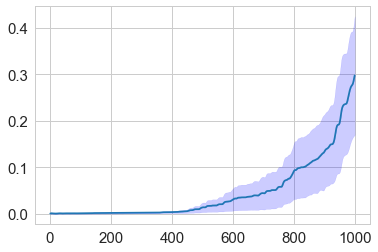

In [18]:
iter_errors = []
iter_stds = []
for i in range(1, len(y_valid)):
    err_is = []
    for j in range(len(predics)):
        err_is.append(nrmse(predics[j, :i], y_valid[:i], data_mean))
    err_is = np.array(err_is).reshape(10, 1)
    iter_errors.append(np.mean(err_is))
    iter_stds.append(np.std(err_is))

iter_errors, iter_stds = np.array(iter_errors), np.array(iter_stds)
err_plus = iter_errors + iter_stds
err_minus = iter_errors - iter_stds

plt.plot(xs[1:], iter_errors)
plt.fill_between(xs[1:], err_plus, iter_errors, alpha=0.2, color='blue')
plt.fill_between(xs[1:], iter_errors, err_minus, alpha=0.2, color='blue')
plt.show()

# View best EESN grid-search results

In [21]:
res_files = os.listdir('Results/EESN')
#print(res_files)

results = pkl.load(open('Results/EESN/Tue-Mar-20-16:55:57-2018.p'))
results_list = results.items()
print(len(results_list))
results_list = sorted(results_list, key=lambda x: np.mean(x[1]))

for k, v in results_list[:3]:
    print(k)
    print(v)

645

        num_res: 10
res_sizes:[ 10  64 118 173 227 282 336 391 445 500]
echo_params:[0.84999999999999998, 0.81111111111111112, 0.77222222222222214, 0.73333333333333328, 0.69444444444444442, 0.65555555555555556, 0.6166666666666667, 0.57777777777777772, 0.53888888888888886, 0.5]
input_scales:[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
spectral_scales:[0.5, 0.58333333333333337, 0.66666666666666663, 0.75, 0.83333333333333326, 0.91666666666666663, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25]
        regulariser: 0.000100
[0.26220810789911614, 0.47968106331103139, 0.08006542228387277]

        num_res: 10
res_sizes:[ 10  64 118 173 227 282 336 391 445 500]
echo_params:[0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998]
input_scales:[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
spectral_scales:[0.5, 0.583333333333

# Run EESN experiments

Took 9.210636 seconds.
NRMSE: 93.783850


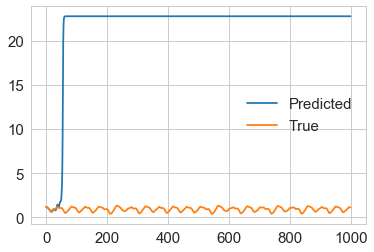

Took 9.695778 seconds.
NRMSE: 92.955171


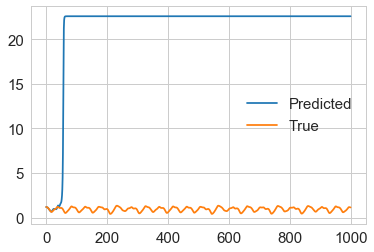

KeyboardInterrupt: 

In [8]:
def run_tests_EESN(n_runs=10, show_plots=False):
    
    errors = []
    for _ in range(n_runs):
        data = np.array(run(15100)).reshape(-1, 1)[::-1]
        split = 14100
        X_train = np.array(data[:split-1])
        y_train = np.array(data[1:split])
        X_valid = np.array(data[split-1:-1])
        y_valid = np.array(data[split:])
        data_mean = np.mean(data)
        
        start_time = time.time()

        model = EESN(
            1, 1, num_reservoirs=10, 
            reservoir_sizes = np.linspace(200, 200, 10).astype(int),
            echo_params=np.linspace(0.5, 0.85, 10),
            regulariser=1e-4
        )
        model.initialize_input_weights(
            scales=np.linspace(0.5, 0.5, 10)
        )
        model.initialize_reservoir_weights(
            spectral_scales=np.linspace(1.0, 1.0, 10) #spectral_scales=np.linspace(1.25, 1.25, 10)
        )

        model.train(X_train, y_train)

        y_pred = []
        u_n = np.array(X_valid[0])
        for _ in range(len(data[split:])):
            u_n = np.array(model.forward(u_n))
            y_pred.append(u_n)

        print('Took %f seconds.' % (time.time() - start_time))

        y_pred = np.array(y_pred).squeeze()

        error = nrmse(y_valid, y_pred, data_mean)
        print('NRMSE: %f' % error)
        errors.append(error)
        
        if show_plots:
            xs = range(len(y_pred))
            f, ax = plt.subplots()
            ax.plot(xs, y_pred, label='Predicted')
            ax.plot(xs, y_valid, label='True')
            plt.legend()
            plt.show()

    raw_input('Press enter to save these results.')
    to_save = dict()
    to_save[model.info()] = errors

    title = 'Results/EESN/GOOD'+time.asctime()[3:-5].replace(' ', '-')+'.p'
    if USE_NEW_DATA:
        title = 'NEW_DATA_' + title
    pkl.dump(to_save, open(title, 'wb'))
    
    return errors
    
errors_eesn = run_tests_EESN(n_runs=2, show_plots=True)

# View best ESN grid-search results

In [6]:
res_files = os.listdir('Results/ESN')
#print(res_files)

results = pkl.load(open('Results/ESN/Tue-Mar-20-16:56:03-2018.p'))
results_list = results.items()
print(len(results_list))
results_list = sorted(results_list, key=lambda x: np.max(x[1]))

for k, v in results_list[:3]:
    print(k)
    print(v)
    #raw_input()
    
print(len([(k, v) for (k, v) in results_list if 'e_prm:0.2' not in k]))

1294
r_size:1250
e_prm:0.200000
i_scl:0.200000
s_scl:0.783333
sp:1.000000
reg:0.010000
[0.59374716471616151, 0.63086498194888185, 0.5897664440800624]
r_size:1000
e_prm:0.200000
i_scl:0.200000
s_scl:0.783333
sp:1.000000
reg:0.010000
[0.6052917556094054, 0.6524202603574093, 0.60722586768743891]
r_size:500
e_prm:0.200000
i_scl:0.200000
s_scl:0.900000
sp:1.000000
reg:0.010000
[0.61426149726150781, 0.66452417883158077, 0.59521014896558144]
0


# Run ESN experiments

Took 7.772306 seconds.
NRMSE: 0.641257
(1000, 1000)


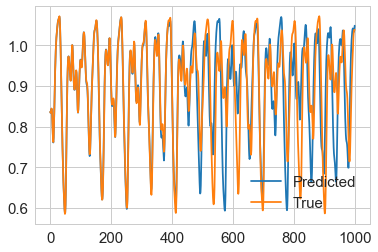

Took 8.390669 seconds.
NRMSE: 0.675053
(1000, 1000)


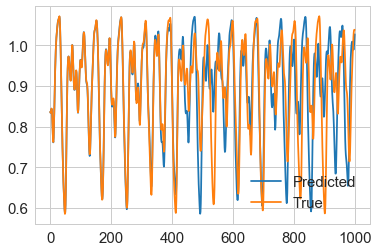

KeyboardInterrupt: 

In [4]:
def run_tests_ESN(n_runs=10, show_plots=False):
    errors = []
    for _ in range(n_runs):
        start_time = time.time()

        model = ESN(
            1, 1, reservoir_size=1000,
            echo_param=0.85,
            regulariser=1e-5
        )
        model.initialize_input_weights(scale=1.0)
        model.initialize_reservoir_weights(strategy='uniform', spectral_scale=1.25)

        model.train(np.array(X_train), np.array(y_train))

        y_pred = []
        #u_n = np.array(data[split-1])
        u_n = np.array(X_valid[0])
        for _ in range(len(data[split:])):
            u_n = np.array(model.forward(u_n))
            y_pred.append(u_n)

        print('Took %f seconds.' % (time.time() - start_time))

        y_pred = np.array(y_pred).squeeze()

        error = nrmse(y_valid, y_pred, data_mean)
        print('NRMSE: %f' % error)
        errors.append(error)
        
        if show_plots:
            print(len(y_valid), len(y_pred))
            f, ax = plt.subplots()
            xs = range(len(y_pred))
            ax.plot(xs, y_pred, label='Predicted')
            ax.plot(xs, y_valid, label='True')
            plt.legend()
            plt.show()

    raw_input('Press enter to save these results.')
    to_save = dict()
    to_save[model.info()] = errors

    title = 'Results/ESN/GOOD'+time.asctime()[3:-5].replace(' ', '-')+'.p'
    if USE_NEW_DATA:
        title = 'NEW_DATA_' + title
    pkl.dump(to_save, open(title, 'wb'))
    
    return errors
    
errors = run_tests_ESN(n_runs=2, show_plots=True)

# Create nice histograms here

n_failures: 1


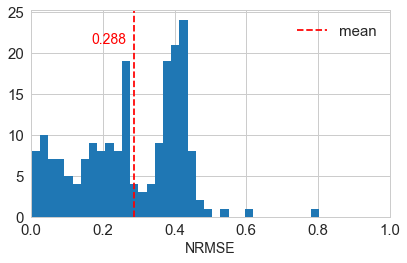

In [12]:
errors = pkl.load(open('Results/LCESN/GOOD-Mar-22-14:14:05.p', 'rb'))
errors = errors.values()[0]
errors_hist = np.array(errors)
errors_hist = errors_hist[np.where(errors_hist <= 1.0)]
mean_error = np.mean(errors_hist)
n_failures = len(errors) - len(errors_hist)
print('n_failures: %d' % n_failures)

hist, bins = np.histogram(errors_hist, bins=35)
bin_width = bins[1] - bins[0]

f, ax = plt.subplots(figsize=(6, 4))
ax.bar(bins[:-1], hist, width=bin_width)
ymin, ymax = ax.get_ylim()
ax.plot(
    [mean_error]*2, [ymin, ymax], linestyle='--', color='red', label='mean'
)
ax.text(
    mean_error-0.12, ymax-4, '%.3f' % mean_error, color='red', fontsize=14
)

ax.set_ylim([ymin, ymax])
ax.set_xlim([0, 1.0])
ax.set_xlabel('NRMSE', fontsize=14)

plt.tight_layout()
plt.legend()
f.savefig('LCESN-hist-valid.pdf')
plt.show()